# Distribution drift

The objective of this practical is to observe, detect and mitigate concept drift on a simple real-world dataset.

## Import package

It is good practice to import all necessary packages at the top of Python files or in the first code cell of a Python notebook.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import sklearn
import mlc
from mlc.datasets.dataset_factory import get_dataset
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from river import drift
from mlc.datasets.dataset_factory import get_dataset
import pandas as pd
from correlation import analyse_loss

We check the correct version are installed.

In [ ]:
for pkg, version in [(mlc, "0.1.0")]:
    if version in pkg.__version__:
        print(f"OK: {pkg.__name__}=={pkg.__version__}.")
    else:
        print(f"Version mismatch: expected version {version} for package {pkg.__name__} but is currently {pkg.__version__}")

## Retrieve data

In this section we will download and load a feature engineered version of the Electricity dataset. The task is a binary classification problem. We try to determine if the price of electricity of a particular region will go UP or DOWN based on neighbouring regions, offer and demand. More details: https://www.openml.org/search?type=data&sort=runs&id=151&status=active.


In [ ]:
dataset = openml.datasets.get_dataset(151)
x, y, _, _ = dataset.get_data(dataset_format="dataframe")
y = x.pop("class").to_numpy()
y = (y == "UP").astype(float)
t = x.pop("date")
x["day"] = x["day"].astype(float)

In [ ]:
dataset = get_dataset("lcld_201317_ds_time")
x, y, t = dataset.get_x_y_t()


In [ ]:
# Features of the dataset
x.dtypes

In [ ]:
# Splitting the data
# We consider the training set to be the first 8k examples, and the validation set the following 2k.
N_TRAIN = 380000
N_VAL = 400000
x_train, x_val, x_test = x.iloc[:N_TRAIN].to_numpy(), x.iloc[N_TRAIN:N_VAL].to_numpy(), x.iloc[N_VAL:].to_numpy()
y_train, y_val, y_test = y[:N_TRAIN], y[N_TRAIN:N_VAL], y[N_VAL:]

for e in [x_train, x_val, x_test]:
    print(e.shape)

Neural networks needs scaled data to obtain the best performance.
We usually use min/max or standard scaling.
Attacks from image classification also suppose min/max scaling in the [0 , 1] range.
For simplicity we will use min/max scaling in this notebook.

## Train model

In [ ]:
args_model = {
    "name": "torchrln",
    # "objective": "classification",
    "batch_size": 1024,
    "epochs": 100,
    "early_stopping_rounds": 100,
    "learning_rate": 0.0009711986977781936,
    "val_batch_size": 2048,
    "class_weight": "balanced",
    "weight_decay": 0,
    "force_device": "cpu",
    "is_text": False,
    "num_classes": 2,
    "n_layers": 2,
    "hidden_dim": 81,
    "norm": 1,
    "theta": -11,
    "depth": 12,
    "heads": 2,
    "dropout": 0.5,
    "model_name": "torchrln",
    "dataset": "lcld_v2_iid",
    "num_splits": 5,
    "seed": 42,
    "shuffle": True,
    "metrics": ["auc"],
}

In [ ]:
from mlc.models.model_factory import get_model
from mlc.transformers.tab_scaler import TabScaler


scaler = TabScaler(one_hot_encode=True)
scaler.fit(torch.from_numpy(x_train).float())


model_arch = get_model("torchrln")
# model = model_arch(scaler, x_metadata=dataset.get_metadata(only_x=True), batch_size=1024, epochs=5, early_stopping_rounds=5, num_classes=2, n_layers=10, hidden_dim=5,class_weight="balanced")
model = model_arch(scaler, x_metadata=dataset.get_metadata(only_x=True), **args_model)

In [ ]:
from mlc.dataloaders import get_custom_dataloader

data_loader = get_custom_dataloader(
    "madry",
    dataset,
    model,
    scaler,
    {},
    verbose=1,
    x=x_train,
    y=y_train,
    train=True,
    batch_size=1024,
)

In [ ]:
data_loader_madry_far = get_custom_dataloader(
    "madry",
    dataset,
    model,
    scaler,
    {"attack_params": {"eps": 1, "norm": "L2"}},
    verbose=1,
    x=x_train,
    y=y_train,
    train=True,
    batch_size=1024,
)
model_far = model_arch(scaler, x_metadata=dataset.get_metadata(only_x=True), **args_model)
model_far.fit(
    torch.from_numpy(x_train).float(),
    torch.from_numpy(np.array([1 - y_train, y_train]).T),
    torch.from_numpy(x_val).float(),
    torch.from_numpy(np.array([1 - y_val, y_val]).T).float(),
    custom_train_dataloader=data_loader_madry_far,
)

In [ ]:
print((model.predict(x_test)==y_test).mean())
print((model_far.predict(x_test)==y_test).mean())
print((model_vanilla.predict(x_test)==y_test).mean())

### Observe the performance of the model overtime

In [ ]:
model.fit(
    torch.from_numpy(x_train).float(),
    torch.from_numpy(np.array([1 - y_train, y_train]).T),
    torch.from_numpy(x_val).float(),
    torch.from_numpy(np.array([1 - y_val, y_val]).T).float(),
    custom_train_dataloader=data_loader,
)

In [ ]:
model_vanilla = model_arch(scaler, x_metadata=dataset.get_metadata(only_x=True), **args_model)
model_vanilla.fit(
    torch.from_numpy(x_train).float(),
    torch.from_numpy(np.array([1 - y_train, y_train]).T),
    torch.from_numpy(x_val).float(),
    torch.from_numpy(np.array([1 - y_val, y_val]).T).float(),
    # custom_train_dataloader=data_loader,
)

In [ ]:
y_score = model.predict_proba(torch.from_numpy(x_test).float())


In [ ]:
print(y_score[:, 0].max())
print(y_score[:, 0].min())
print(y_score[:, 1].max())
print(y_score[:, 1].min())

In [ ]:
print(roc_auc_score(y_test, y_score[:, 1]))

In [ ]:
y_score_sm = softmax(y_score, axis=1)

In [ ]:
y_pred = np.argmax(y_score_sm, axis=1)

In [ ]:
print(roc_auc_score(y_test, y_score_sm[:, 1]))

In [ ]:
y_pred = np.argmax(y_score, axis=1)

In [ ]:
print((y_pred == y_test).mean())

In [ ]:
y_pred_new = y_pred.copy()
y_pred_new[y_score_sm.max(axis=1) < 0.6] = 1 - y_pred_new[y_score_sm.max(axis=1) < 0.6]

In [ ]:
print((y_pred_new == y_test).mean())

In [ ]:
print((y_pred[y_score_sm.max(axis=1) < 0.6] == y_test[y_score_sm.max(axis=1) < 0.6]).mean())

## RF Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(class_weight="balanced", n_estimators=100, max_depth=10, verbose=1, n_jobs=-1)
rf.fit(scaler.transform(x_train), y_train)

In [ ]:
scaler.transform(x_train).shape

In [ ]:
x_test.shape

In [ ]:
max_score = rf.predict_proba(scaler.transform(x_test))
max_score[1]

In [ ]:
np.max(max_score[0] - max_score[1])

In [ ]:
df = pd.DataFrame({"max_score": rf.predict_proba(x_test).max(1), "correct_pred": rf.predict(x_test)==y_test})
sns.boxplot(data=df, x="correct_pred", y="max_score", showfliers=False)

## Distribution drift

### Observe the performance of the model overtime

Compute the rolling accuracy of a N example window for y_test. Plot the graph of your results. Adapt N such that the graph is readable.
You should observe clear degradation of performance.

In [ ]:
# CORRECTION

N_ROLLING = 10000
def rolling_mean(arr, window):
    # Create a 1D kernel with all elements equal to 1/window
    kernel = np.ones(window) / window

    # Use np.convolve to compute the rolling mean
    result = np.convolve(arr, kernel, mode='valid')

    return result


correct_pred = (np.argmax(y_score, 1) == y_test).astype(int)
acc_mean = rolling_mean(correct_pred, N_ROLLING)
sns.lineplot(acc_mean)

### Understand the source of drift

You should observe that the performance of the model decrease over time and eventually climbs up again. Select 2 time window in x_test, one from the first input until the performance start to degrade and the second one corresponding to the worst performance. (e.g. [0, 15000], [15000, 20000]).
For this two time windows, and for each feature, plot the histogram  grouped by the target class (i.e. each class as a color on the histogram). You can easily do that with the seaborn library.

In [ ]:
# CORRECTION
SPLIT_1 = N_VAL+ 2000
SPLIT_2 = N_VAL + 4000

test_1 = x.iloc[N_VAL:SPLIT_1].copy()
test_1["y"] = y_test[N_VAL:SPLIT_1]

test_2 = x.iloc[SPLIT_1:SPLIT_2].copy()
test_2["y"] = y_test[SPLIT_1:SPLIT_2]


In [ ]:
# CORRECTION

for feature in x.columns:
    plt.figure(figsize=(12, 6))

    # Plot histograms for data1
    plt.subplot(1, 2, 1)
    sns.histplot(data=test_1, x=feature, hue='y', kde=True, bins=30)
    plt.xlabel(feature)
    plt.title(f'Dataset 1 - Histogram of {feature}')
    plt.legend(title='Class')

    # Plot histograms for data2
    plt.subplot(1, 2, 2)
    sns.histplot(data=test_2, x=feature, hue='y', kde=True, bins=30)
    plt.xlabel(feature)
    plt.title(f'Dataset 2 - Histogram of {feature}')
    plt.legend(title='Class')

    plt.tight_layout()
    plt.show()

Which feature drifted the most and for which class? Comment.

### Mitigating drift: online-learning

Implement an online learning test-then-train loop. Don't forget to store the precition. You can batch examples for performance.

In [ ]:
# CORRECTION

BATCH_SIZE=256
N_BATCH = x_test.shape[0] // BATCH_SIZE +1
preds_online = []
for i in tqdm(range(N_BATCH)):
    x_now = x_test[i * BATCH_SIZE: (i+1) * BATCH_SIZE]
    y_now = y_test[i * BATCH_SIZE: (i+1) * BATCH_SIZE]
    preds_online.append(model(torch.from_numpy(x_now).float()).detach().numpy())
    train_model(
        model,
        torch.from_numpy(x_now).float(),
        torch.from_numpy(np.array([1 - y_now, y_now]).T).float(),
        None,
        None,
        optimizer,
        BATCH_SIZE,
        loss,
        1
    )

preds_online = np.concatenate(preds_online)

Compare the performance with the original model.

In [ ]:
# CORRECTION
correct_pred = (np.argmax(preds_online, 1) == y_test).astype(int)
acc_mean_online = rolling_mean(correct_pred, N_ROLLING)

sns.lineplot(x=np.arange(len(acc_mean)), y=acc_mean, label='No retraining')
sns.lineplot(x=np.arange(len(acc_mean)), y=acc_mean_online, label='Online')


### Mitigating drift: Drift detector

Using a similar loop, after each test, use ADWIN to detect drift. If a drift is detected, use all data up current test example (including the train set) to retrain the model.
Use the ADWIN drift detector from the River library https://riverml.xyz/dev/api/drift/ADWIN/ and retrain with the store examples when you detect drift.
Store and display the number of used model.

In [ ]:
# CORRECTION

BATCH_SIZE=256
N_BATCH = x_test.shape[0] // BATCH_SIZE +1
preds_adwin = []
adwin = drift.ADWIN(delta=0.0001, grace_period=BATCH_SIZE)

new_model = nn.Sequential(ScalerModule(scaler), Net()).float()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, new_model.parameters()),
    lr=0.001,
)
train_model(
    new_model,
    torch.from_numpy(x_train).float(),
    torch.from_numpy(np.array([1 - y_train, y_train]).T).float(),
    None,
    None,
    optimizer,
    64,
    loss,
    1
)

n_model = 1

for i in tqdm(range(N_BATCH)):
    x_now = x_test[i * BATCH_SIZE: (i+1) * BATCH_SIZE]
    y_now = y_test[i * BATCH_SIZE: (i+1) * BATCH_SIZE]
    pred_now = model(torch.from_numpy(x_now).float()).detach().numpy()
    preds_adwin.append(pred_now)

    correct_pred = y_now == np.argmax(pred_now, 1)
    acc = correct_pred.mean()
    for e in correct_pred:
        _ = adwin.update(e)
        if adwin.drift_detected:
            print(f"Change detected at index {i}, input value: {i}")
            x_now_t = x.iloc[:N_VAL + (i+1) * BATCH_SIZE].to_numpy()
            y_now_t = y[:N_VAL + (i+1) * BATCH_SIZE]

            new_model = nn.Sequential(ScalerModule(scaler), Net()).float()
            optimizer = optim.AdamW(
                filter(lambda p: p.requires_grad, new_model.parameters()),
                lr=0.001,
            )

            print(x_now_t.shape)
            print(y_now_t.shape)
            train_model(
                new_model,
                torch.from_numpy(x_now_t).float(),
                torch.from_numpy(np.array([1 - y_now_t, y_now_t]).T).float(),
                None,
                None,
                optimizer,
                64,
                loss,
                1
            )
            n_model += 1
            break


preds_adwin = np.concatenate(preds_adwin)

Compare the performance with the original model and online learning. Print the number of models

In [ ]:
# CORRECTION
correct_pred = (np.argmax(preds_adwin, 1) == y_test).astype(int)
acc_mean_adwin = rolling_mean(correct_pred, N_ROLLING)

sns.lineplot(x=np.arange(len(acc_mean)), y=acc_mean, label='No retraining')
sns.lineplot(x=np.arange(len(acc_mean)), y=acc_mean_online, label='Online')
sns.lineplot(x=np.arange(len(acc_mean)), y=acc_mean_adwin, label='Detector')
print(f"Number of model trained: {n_model}")


Comment your results.

## Adversarial drift

In [ ]:
from constrained_attacks.attacks.cta.cfab import CFAB
from mlc.constraints.constraints import Constraints

constraints = Constraints(
    feature_types=np.array(["real"] * x.shape[1]),
    mutable_features=np.array([True] * x.shape[1]),
    lower_bounds=scaler.x_min,
    upper_bounds=scaler.x_max,
    relation_constraints=None,
    feature_names=None,
)


attack = CFAB(
    constraints,
    scaler,
    model.wrapper_model,
    model.predict_proba,
    norm="L2",
    eps=10,
    steps=100,
    n_restarts=5,
    alpha_max=0.1,
    eta=1.05,
    beta=0.9,
    verbose=False,
    seed=0,
    multi_targeted=False,
    n_classes=10,
    fix_equality_constraints_end=False,
    fix_equality_constraints_iter=False,
    eps_margin=0.01,
)

In [ ]:
x_orig, y_orig = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float()
x_orig = x_orig[:5000]
y_orig_pred = torch.argmax(torch.from_numpy(model.predict_proba(x_orig)), 1).float()
x_adv = attack(
    x_orig.to("cuda"),
    y_orig_pred.to("cuda"),
).cpu().detach()

In [ ]:
distance = np.linalg.norm(scaler.transform(x_adv) - scaler.transform(x_orig), axis=1)
sns.boxplot(distance, showfliers=False)

In [ ]:
misclassified = np.argmax(model.predict_proba(x_adv), 1) != y_orig_pred.numpy()
print(f"Number of misclassified examples: {misclassified.mean()}")

In [ ]:
correct_pred = (np.argmax(y_score, 1) == y_test).astype(int)
acc_mean = rolling_mean(correct_pred, N_ROLLING)
sns.lineplot(acc_mean)

distance_mean = rolling_mean(distance, N_ROLLING)
sns.lineplot(distance_mean)

In [ ]:
# Create the first plot (left y-axis)

curve_1 = "Accuracy"
curve_2 = "Distance"
sample = 1000

plt.figure(figsize=(10, 6))
ax1 = sns.lineplot(acc_mean[:sample], color='blue', label=curve_1)
ax1.set_ylabel(curve_1, color='blue')

# Create the second plot (right y-axis)
ax2 = ax1.twinx()
sns.lineplot(distance_mean[:sample], color='red', ax=ax2, label=curve_2)
ax2.set_ylabel(curve_2, color='red')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

In [ ]:
sns.lineplot(distance_mean)

In [ ]:
np.corrcoef(distance_mean, acc_mean)

In [ ]:
corr_coeffs = []

for i in range(1, 20):
    n_shift = i * 1000
    print(n_shift)
    distance_l = distance_mean[:-n_shift]
    acc_l = acc_mean[n_shift:]
    corr_coeffs.append(np.corrcoef(distance_l, acc_l)[0, 1])
    

In [ ]:
corr_coeffs

In [ ]:
np.corrcoef(distance, correct_pred)[0, 1]

In [ ]:
from scipy.special import softmax
y_score_softmax = softmax(y_score, axis=1)

y_score_correct = y_score_softmax[:,0]
y_score_correct[y_test ==1 ] = y_score_softmax[:,1][y_test ==1]

In [ ]:
np.corrcoef(distance, y_score_correct)[0, 1]

In [ ]:
df = pd.DataFrame({"distance": distance, "y_score": y_score_correct, "correct_pred": correct_pred})
df = df.sample(10000)
sns.scatterplot(data=df, x="distance", y="y_score", hue="correct_pred")

In [ ]:
df = pd.DataFrame({"distance": distance, "correct_pred": correct_pred})
sns.boxplot(data=df, x="correct_pred", y="distance", showfliers=False)

In [ ]:
np.corrcoef(distance, y_score_correct)[0, 1]

In [ ]:
loss = nn.CrossEntropyLoss(reduction="none")
loss(torch.from_numpy(y_score), torch.from_numpy(y_test)).detach().numpy().shape

In [ ]:
loss = nn.CrossEntropyLoss(reduction="none")

df = pd.DataFrame({"max_score": y_score_softmax.max(1), "correct_pred": correct_pred, "loss": loss(torch.from_numpy(y_score), torch.from_numpy(y_test)).detach().numpy()})
sns.boxplot(data=df, x="correct_pred", y="max_score", showfliers=False)

In [ ]:
df = pd.DataFrame({"distance": distance, "loss": loss(torch.from_numpy(y_score), torch.from_numpy(y_test)).detach().numpy()})


data = df.sample(11000)
data = data[(data["loss"] < 1) & (data["distance"] <  0.2)]
print(data.shape)
sns.scatterplot(data=data, x="loss", y="distance")

In [ ]:
np.corrcoef(y_score_softmax.max(1), y_score_correct)[0, 1]

In [ ]:
np.unique(correct_pred, return_counts=True)

In [ ]:
def window_mean(arr, win):
    arr.copy()
    arr = arr[:-(arr.shape[0] % win)]
    arr = arr.reshape(-1, win)
    return arr.mean(1)

In [ ]:
WINDOW_SIZE = 10
distance_win = window_mean(distance, WINDOW_SIZE)
acc_mean_win = window_mean(correct_pred, WINDOW_SIZE)

In [ ]:
curve_1 = "Accuracy"
curve_2 = "Distance"
sample = 50

plt.figure(figsize=(10, 6))
ax1 = sns.lineplot(acc_mean_win[:sample], color='blue', label=curve_1)
ax1.set_ylabel(curve_1, color='blue')

# Create the second plot (right y-axis)
ax2 = ax1.twinx()
sns.lineplot(distance_win[:sample], color='red', ax=ax2, label=curve_2)
ax2.set_ylabel(curve_2, color='red')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

In [ ]:
np.corrcoef(distance_win, acc_mean_win)

In [ ]:
x_adv_pred, x_adv_test = None, None

success rate pred:  0.9496346980289978
success rate test:  0.9573933972393273


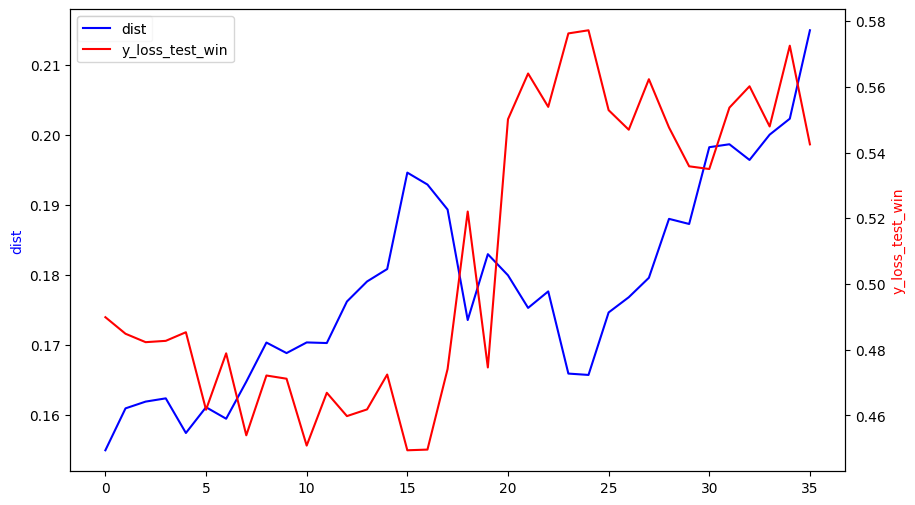

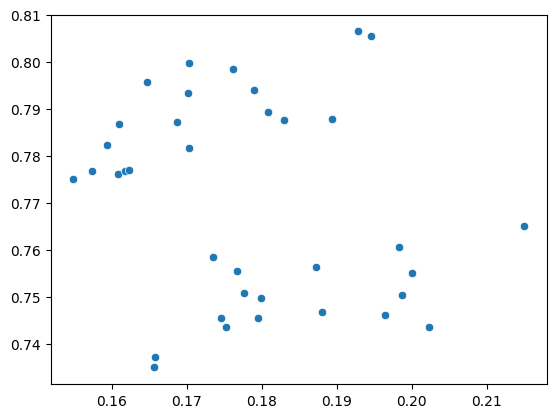

[[1.         0.34550357]
 [0.34550357 1.        ]]


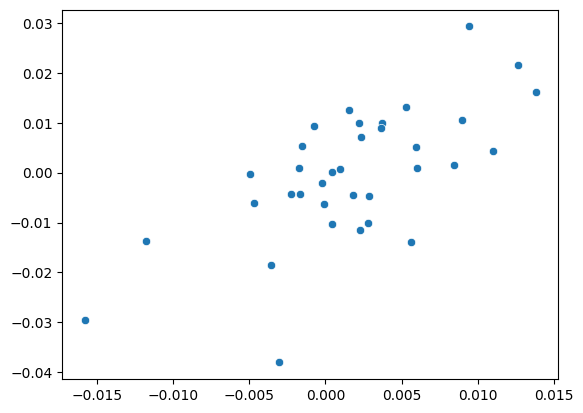

[[ 1.         -0.66897172]
 [-0.66897172  1.        ]]


In [387]:
from correlation import analyse

x_adv_pred, x_adv_test = analyse(
    model,
    scaler,
    torch.from_numpy(x_test).float().to("cuda"),
    torch.from_numpy(y_test),
    x_adv_pred,
    x_adv_test,
)

In [ ]:
x_adv_pred_far, x_adv_test_far = None, None


In [ ]:
x_adv_pred_far, x_adv_test_far = analyse(
    model_far,
    scaler,
    torch.from_numpy(x_test).float().to("cuda"),
    torch.from_numpy(y_test),
    x_adv_pred_far,
    x_adv_test_far,
)

In [ ]:
x_adv_pred_vanilla, x_adv_test_vanilla = None, None


In [ ]:
x_adv_pred_vanilla, x_adv_test_vanilla = analyse(
    model_vanilla,
    scaler,
    torch.from_numpy(x_test).float().to("cuda"),
    torch.from_numpy(y_test),
    x_adv_pred_vanilla,
    x_adv_test_vanilla,
)

In [ ]:
analyse_loss(
    model,
    torch.from_numpy(x_test).float().to("cuda"),
    torch.from_numpy(y_test),
)

In [ ]:
analyse_loss(
    model_vanilla,
    torch.from_numpy(x_test).float().to("cuda"),
    torch.from_numpy(y_test),
)

In [ ]:
from sklearn.metrics import matthews_corrcoef
BATCH_SIZE=20000

In [ ]:
y_pred = model.predict(x_test)
y_score = model.predict_proba(x_test)
size = (BATCH_SIZE * (x_test.shape[0] // BATCH_SIZE))
batch = np.split(
    np.arange((BATCH_SIZE * (x_test.shape[0] // BATCH_SIZE))),
    size / BATCH_SIZE,
)

In [ ]:
mcc_win = []
BATCH_HISTORY = 4
for i in range(size // BATCH_SIZE - 4):
    mcc_win.append(
        matthews_corrcoef(
            y_test[(i) * BATCH_SIZE : (i + BATCH_HISTORY) * BATCH_SIZE],
            y_pred[(i) * BATCH_SIZE : (i + BATCH_HISTORY) * BATCH_SIZE],
        )
    )
mcc_win = np.array(mcc_win)

In [ ]:
sns.lineplot(mcc_win)

In [ ]:
from correlation import distance
dist = distance(scaler, x_test, x_adv_pred)

In [ ]:
dist_win = []
BATCH_HISTORY = 4
for i in range(size // BATCH_SIZE - 4):
    dist_win.append(
        np.mean(
            dist[(i) * BATCH_SIZE : (i + BATCH_HISTORY) * BATCH_SIZE],
        )
    )
dist_win = np.array(dist_win)

In [ ]:
sns.lineplot(mcc_win)
sns.lineplot(dist_win)

In [390]:
loss_win = []
loss = nn.CrossEntropyLoss(reduction="none")
for i in range(size // BATCH_SIZE - 4):
    loss_win.append(
        loss(
            torch.from_numpy(y_score[(i) * BATCH_SIZE : (i + BATCH_HISTORY) * BATCH_SIZE]),
            torch.from_numpy(y_pred[(i) * BATCH_SIZE : (i + BATCH_HISTORY) * BATCH_SIZE]),
        ).mean()
    )
loss_win = np.array(loss_win)

<AxesSubplot: >

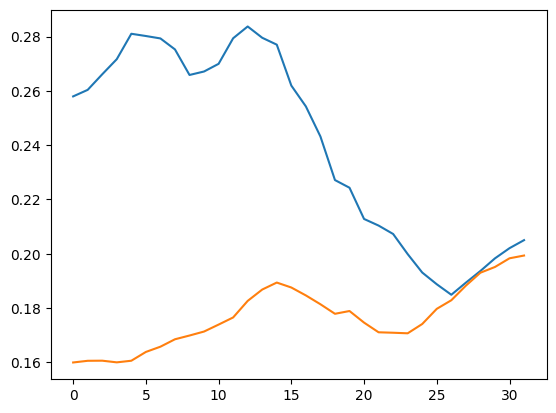

In [391]:
sns.lineplot(mcc_win)
sns.lineplot(dist_win)
# sns.lineplot(loss_win)

In [392]:
dist_corr=[]
loss_corr=[]
total = len(mcc_win)
for i in range(len(mcc_win) // 2):

    dist_corr.append(np.corrcoef(mcc_win[i:], dist_win[:total-i])[0, 1])
    loss_corr.append(np.corrcoef(mcc_win[i:], loss_win[:total-i])[0, 1])
    


<AxesSubplot: >

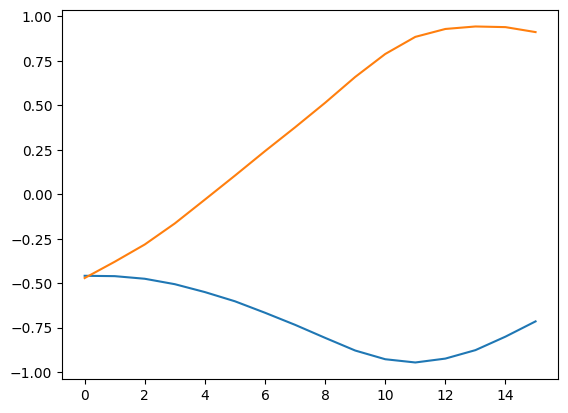

In [393]:
sns.lineplot(dist_corr)
sns.lineplot(loss_corr)

In [394]:
mcc_win_delta = mcc_win[1:] - mcc_win[:-1]
dist_win_delta = dist_win[1:] - dist_win[:-1]
loss_win_delta = loss_win[1:] - loss_win[:-1]

In [395]:
for e in [mcc_win_delta, dist_win_delta, loss_win_delta]:
    print(e.shape)

(31,)
(31,)
(31,)


In [396]:
dist_corr=[]
loss_corr=[]
total = len(mcc_win_delta)
for i in range(len(mcc_win_delta) // 2):

    dist_corr.append(np.corrcoef(mcc_win_delta[i:], dist_win_delta[:total-i])[0, 1])
    loss_corr.append(np.corrcoef(mcc_win_delta[i:], loss_win_delta[:total-i])[0, 1])
    

<AxesSubplot: >

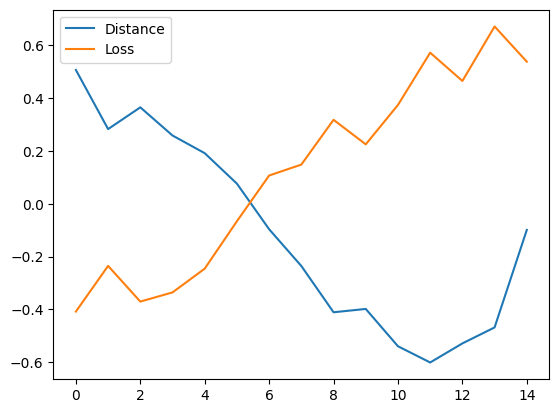

In [397]:
sns.lineplot(dist_corr, label="Distance")
sns.lineplot(loss_corr, label="Loss")

In [ ]:
print(dist_corr[4])
print(loss_corr[4])